In [1]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
#from AutoEncoderCNN import AE_CNN
from nn_trainer import ae_train

from util.custom_loss.custom_loss import mse_loss, sparsity_loss, dirichlet_loss
from util.ImageFolderWithPaths import ImageFolderWithPaths
from util.random_patient import random_split

In [2]:
print(torch.cuda.device_count())
torch.cuda.empty_cache()
torch.cuda.mem_get_info()

1


(16319119360, 17059545088)

In [3]:
BATCH_SIZE = 4

# setting the correct device to train on
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_device(device)

MAIN_PATH = '/home/u6/njcrutchfield/torch/NN/pill_data/pillQC-main/images' # images are 225 x 225 x 3
# PATH1 = '/groups/francescavitali/eb2/NewsubSubImages4/H&E/A'
# PATH2 = '/groups/francescavitali/eb2/NewsubSubImages4/H&E/S'

tensor_transform = transforms.ToTensor()
horizontal_flip = transforms.RandomHorizontalFlip(p=1)

# Dataset of both normal and horizontal flipped images
dataset = datasets.ImageFolder(MAIN_PATH, transform = tensor_transform) + datasets.ImageFolder(MAIN_PATH, transform=transforms.Compose([
                                                                                                                     tensor_transform,
                                                                                                                     horizontal_flip
                                                                                                                   ]))


In [4]:
SPLIT = [528, 66, 66]
train_set, _, _ = torch.utils.data.random_split(dataset,
                                                SPLIT,# 80%, 10%, 10%
                                                generator=torch.Generator(device=device))

train_loader = torch.utils.data.DataLoader(dataset = train_set,
                                            batch_size = BATCH_SIZE,
                                            shuffle = True,
                                            generator=torch.Generator(device=device))

In [5]:
# Nate Code
class AE_CNN(torch.nn.Module):
    def __init__(self, encoded_dim:int=2048, rand_mat_dim:int=1024, rand_mat = True) -> None:
        super().__init__()
        
        self.encoded_vector = None
        
        if rand_mat: 
            self.rand_mat = self.create_rand_mat(rand_mat_dim, encoded_dim)
        else:
            self.rand_mat = torch.randn(rand_mat_dim, encoded_dim, requires_grad=False, device='cuda' if torch.cuda.is_available() else 'cpu') # dummy rand matrix of correct dim
        
        self.softmax = torch.nn.Softmax(dim=1)
        
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(3,16,3,stride=1,padding=1, bias=False), 
            torch.nn.BatchNorm2d(16), torch.nn.ReLU(),
            
            torch.nn.Conv2d(16,32,3,stride=1,padding=1, bias=False), 
            torch.nn.BatchNorm2d(32),torch.nn.ReLU(),
            
            torch.nn.AvgPool2d(2,stride=2, padding=1), 
            torch.nn.Conv2d(32,64,3,stride=1,padding=1, bias=False), 
            torch.nn.BatchNorm2d(64),torch.nn.ReLU(),
            
            torch.nn.AvgPool2d(2,stride=2, padding=1), 
            torch.nn.Conv2d(64,128,3,stride=1,padding=1, bias=False), 
            torch.nn.BatchNorm2d(128),torch.nn.ReLU(),
            
            torch.nn.AvgPool2d(2,stride=2, padding=1), 
            torch.nn.Conv2d(128,320,3,stride=1,padding=1, bias=False), 
            torch.nn.BatchNorm2d(320),torch.nn.ReLU(),
            
            torch.nn.Conv2d(320,240,3,stride=1,padding=1, bias=False), 
            torch.nn.BatchNorm2d(240),torch.nn.ReLU(),
            
            torch.nn.Conv2d(240,150,3,stride=1,padding=1, bias=False), 
            torch.nn.BatchNorm2d(150),torch.nn.ReLU(),
            
            torch.nn.Conv2d(150,80,3,stride=2,padding=1, bias=False), 
            torch.nn.BatchNorm2d(80),torch.nn.ReLU(),
            
            torch.nn.Conv2d(80,40,3,stride=1,padding=1, bias=False), 
            torch.nn.BatchNorm2d(40),torch.nn.ReLU(),
            
            torch.nn.Conv2d(40,15,3,stride=1,padding=1, bias=False), # Outputs: 15 x 15 x 15
            torch.nn.BatchNorm2d(15),torch.nn.ReLU(),
            
            
            torch.nn.Flatten(),
            torch.nn.Linear(15*15*15, encoded_dim, bias=False)
        )
        
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(rand_mat_dim, 15*15*15, bias=False), # rand_mat_dim -> flattened dim
            torch.nn.Unflatten(1, (15, 15, 15)),
            
            torch.nn.ConvTranspose2d(15,40,3, stride=1, padding=1, bias=False), 
            torch.nn.BatchNorm2d(40),torch.nn.ReLU(),
            
            torch.nn.ConvTranspose2d(40,80,3, stride=1, padding=1, bias=False), 
            torch.nn.BatchNorm2d(80),torch.nn.ReLU(),
            
            torch.nn.ConvTranspose2d(80,150,3, stride=2, padding=1, bias=False), 
            torch.nn.BatchNorm2d(150),torch.nn.ReLU(),
            
            torch.nn.ConvTranspose2d(150,240,3, stride=1, padding=1, bias=False), 
            torch.nn.BatchNorm2d(240),torch.nn.ReLU(),
            
            torch.nn.ConvTranspose2d(240,320,3, stride=1, padding=1, bias=False), 
            torch.nn.BatchNorm2d(320),torch.nn.ReLU(),
            
            torch.nn.ConvTranspose2d(320,128,3, stride=1, padding=1, bias=False), 
            torch.nn.BatchNorm2d(128),torch.nn.ReLU(),
            
            torch.nn.ConvTranspose2d(128,128,3, stride=2, padding=1, bias=False), 
            torch.nn.ReLU(),
            
            torch.nn.ConvTranspose2d(128,64,3, stride=1, padding=1, bias=False), 
            torch.nn.BatchNorm2d(64),torch.nn.ReLU(),
            
            torch.nn.ConvTranspose2d(64,64,3, stride=2, padding=2, bias=False), 
            torch.nn.ReLU(),
            
            torch.nn.ConvTranspose2d(64,32,3, stride=1, padding=1, bias=False), 
            torch.nn.BatchNorm2d(32),torch.nn.ReLU(),
            
            torch.nn.ConvTranspose2d(32,32,3, stride=2, padding=1, bias=False), 
            torch.nn.ReLU(),
            
            torch.nn.ConvTranspose2d(32,16,3, stride=1, padding=0, bias=False), 
            torch.nn.BatchNorm2d(16),torch.nn.ReLU(),
            
            torch.nn.ConvTranspose2d(16,3,3, stride=1, padding=0, bias=False), 
            torch.nn.Sigmoid()
        )
        
    def create_rand_mat(self, rand_mat_dim:int, encoded_dim:int) -> torch.tensor:
        y = torch.randn(rand_mat_dim, encoded_dim, requires_grad=False, device='cuda' if torch.cuda.is_available() else 'cpu')
        norm = torch.norm(y, dim = 0)
        y = y.div(norm)
        return y
        
    def forward(self, x) -> torch.tensor:
        self.encoded_vector = self.softmax(self.encoder(x))
        all_dps = []
        for batch in self.encoded_vector:
            all_dps.append(torch.mv(self.rand_mat, batch))
        Dp = torch.stack(all_dps)
        decoded = self.decoder(Dp)
        return decoded

In [6]:
encoded_dim = 64
rand_mat_dim = 32 # simple problem try decreasing

In [7]:
AE = AE_CNN(encoded_dim=encoded_dim, rand_mat_dim=rand_mat_dim, rand_mat=True).to(device)

In [8]:
# AE.rand_mat = torch.eye(rand_mat_dim) # has to be square

In [9]:
AE

AE_CNN(
  (softmax): Softmax(dim=1)
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): AvgPool2d(kernel_size=2, stride=2, padding=1)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): AvgPool2d(kernel_size=2, stride=2, padding=1)
    (11): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): AvgPool2d(kernel_size=2, stride=2, padding=1)


In [10]:
AE.rand_mat

tensor([[-0.0418,  0.0483, -0.1317,  ...,  0.0113, -0.1279, -0.0926],
        [-0.3487, -0.2988,  0.3186,  ...,  0.4488, -0.4153,  0.1420],
        [-0.0203, -0.1195,  0.1403,  ...,  0.0222, -0.0363,  0.0762],
        ...,
        [-0.0293,  0.2336, -0.0378,  ...,  0.0668, -0.2445, -0.2346],
        [-0.1413, -0.1002, -0.0823,  ..., -0.0461,  0.2237,  0.3426],
        [ 0.0475, -0.1034, -0.1093,  ...,  0.0401,  0.0110,  0.0994]],
       device='cuda:0')

In [11]:
with open('progress.txt', 'w') as file:
    file.write(f"{AE=}\n\nTraining:\n")

In [12]:
EPOCHS = 100
loss_weights = [1, 0.001, 0] # [1,0,0]
early_stop_depth = 20
verbose = 1

LR = [0.00005] # [0.00005]
WEIGHT_DECAY = [0.05] # [0.01]

In [13]:
torch.autograd.set_detect_anomaly(True)
min_loss = None
d = {}
for lr in LR:
    AE = AE_CNN(encoded_dim=encoded_dim, rand_mat_dim=rand_mat_dim, rand_mat=True).to(device)
    #AE.rand_mat = torch.eye(rand_mat_dim)
    for wd in WEIGHT_DECAY:  
        with open('progress.txt', 'a') as file:
            file.write(f"{lr=} | {wd=}\n")
        optimizer = torch.optim.Adam(AE.parameters(), lr = lr, weight_decay = wd)
        outputs, loss_arr = ae_train(AE, train_loader, optimizer, EPOCHS, loss_weights, early_stop_depth, verbose)
        if loss_arr: # ignore nan
            d[str(lr) + "|"+str(wd)] = loss_arr[-1]
            if not min_loss or min_loss > loss_arr[-1]:
                min_loss = loss_arr[-1]
                torch.save(AE.state_dict(), f'./models/ae_model_gs.pth')
                torch.save(AE.rand_mat, f'./models/ae_model_rand_mat.pth')

                with open('progress.txt', 'a') as file:
                    file.write(f"New AE: {min_loss=}\n")
                print(f"New AE: {min_loss=}\n")

/home/u6/njcrutchfield/.local/lib/python3.8/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass



Epoch: 1 | Loss: 0.0361


Epoch: 2 | Loss: 0.0242


Epoch: 3 | Loss: 0.0158


Epoch: 4 | Loss: 0.0112


Epoch: 5 | Loss: 0.0105


Epoch: 6 | Loss: 0.0117


Epoch: 7 | Loss: 0.0092


Epoch: 8 | Loss: 0.0082


Epoch: 9 | Loss: 0.0118


Epoch: 10 | Loss: 0.0137


Epoch: 11 | Loss: 0.0109


Epoch: 12 | Loss: 0.0108


Epoch: 13 | Loss: 0.0120


Epoch: 14 | Loss: 0.0133


Epoch: 15 | Loss: 0.0133


Epoch: 16 | Loss: 0.0076


Epoch: 17 | Loss: 0.0126


Epoch: 18 | Loss: 0.0099


Epoch: 19 | Loss: 0.0115


Epoch: 20 | Loss: 0.0098


Epoch: 21 | Loss: 0.0144


Epoch: 22 | Loss: 0.0107


Epoch: 23 | Loss: 0.0084


Epoch: 24 | Loss: 0.0163


Epoch: 25 | Loss: 0.0069


Epoch: 26 | Loss: 0.0107


Epoch: 27 | Loss: 0.0130


Epoch: 28 | Loss: 0.0117


Epoch: 29 | Loss: 0.0114


Epoch: 30 | Loss: 0.0122


Epoch: 31 | Loss: 0.0116


Epoch: 32 | Loss: 0.0091


Epoch: 33 | Loss: 0.0130


Epoch: 34 | Loss: 0.0126


Epoch: 35 | Loss: 0.0101


Epoch: 36 | Loss: 0.0137


Epoch: 37 | Loss: 0.0103


Epoch: 38

In [19]:
#torch.save(AE.state_dict(), f'./models/ae_model_gs.pth')
if len(LR) == 1 and len(WEIGHT_DECAY) == 1: # dont save during grid search, should already be saved
    torch.save(AE.rand_mat, f'./models/ae_model_rand_mat.pth')
    torch.save(AE.state_dict(), f'./models/ae_model_gs.pth')

    with open('progress.txt', 'a') as file:
        file.write(f"Saved\n\n")
    print("done")

done


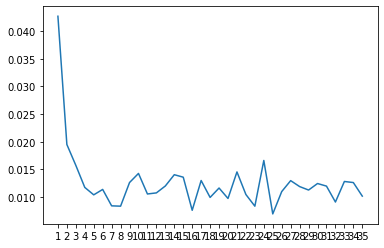

In [20]:
ep = [x+1 for x in range(len(loss_arr))]
plt.plot(ep, loss_arr)
plt.xticks(ep)
plt.show()

In [21]:
print(torch.cuda.mem_get_info())
torch.cuda.empty_cache()

(15585116160, 17059545088)


In [22]:
torch.set_default_device('cuda')

MAIN_PATH = '/home/u6/njcrutchfield/torch/NN/pill_data/pillQC-main/images' # images are 225 x 225 x 3
# PATH1 = '/groups/francescavitali/eb2/NewsubSubImages4/H&E/A'
# PATH2 = '/groups/francescavitali/eb2/NewsubSubImages4/H&E/S'

tensor_transform = transforms.ToTensor()
horizontal_flip = transforms.RandomHorizontalFlip(p=1)


# Dataset of both normal and horizontal flipped images
dataset = datasets.ImageFolder(MAIN_PATH, transform = tensor_transform) + datasets.ImageFolder(MAIN_PATH, transform=transforms.Compose([
                                                                                                                      tensor_transform,
                                                                                                                      horizontal_flip
                                                                                                                    ]))
SPLIT = [528, 66, 66]
_, val_set, _ = torch.utils.data.random_split(dataset,
                                                SPLIT,# 80%, 10%, 10%
                                                generator=torch.Generator(device=device))

val_loader = torch.utils.data.DataLoader(dataset = train_set,
                                            batch_size = 1,
                                            shuffle = True,
                                            generator=torch.Generator(device=device))

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = AE_CNN(encoded_dim=encoded_dim, rand_mat_dim=rand_mat_dim, rand_mat=False).to(device)
model.load_state_dict(torch.load('./models/ae_model_gs.pth'))
model.rand_mat = torch.load('./models/ae_model_rand_mat.pth')

# setting the encoder and decoder for visualization
encoder = model.encoder
decoder = model.decoder
rand_mat = model.rand_mat

In [24]:
# input and output arrays
auto_encoder_output = []
encoded_imgs_arr = []
decoded_imgs_arr = []


mse_running_total = 0
count = 0

torch.set_default_device('cuda')

for (inp, _) in val_loader:
    model.eval()
    with torch.no_grad():
        inp = inp.to(device)
        oup = model(inp)
        encoded_imgs = torch.mv(rand_mat, model.softmax(encoder(inp))[0])
        encoded_imgs_arr.append(encoded_imgs)
        
#         decoded_imgs = decoder(encoded_imgs)
        mse_running_total += np.square(inp.cpu().numpy() - oup.cpu().numpy()).mean()

        
        
        # decoded_imgs_arr.append((inp, decoded_imgs))
        
        if count % 1 == 0:
            auto_encoder_output.append((inp, model(inp)))
        count += 1



In [25]:
mse_running_total/len(val_loader)

0.05604357301313995

In [26]:
import matplotlib.pyplot as plt

In [27]:
x = torch.nn.functional.softmax(encoded_imgs_arr[0])
y = torch.nn.functional.softmax(encoded_imgs_arr[10])

/home/u6/njcrutchfield/.local/lib/python3.8/site-packages/torch/utils/_device.py:78: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return func(*args, **kwargs)


(array([2., 0., 1., 0., 2., 1., 2., 3., 1., 1., 0., 0., 0., 1., 1., 1.]),
 array([0.05504843, 0.05609819, 0.05714795, 0.05819771, 0.05924747,
        0.06029723, 0.06134699, 0.06239675, 0.06344651, 0.06449626,
        0.06554603, 0.06659579, 0.06764555, 0.06869531, 0.06974506,
        0.07079483, 0.07184459], dtype=float32),
 <BarContainer object of 16 artists>)

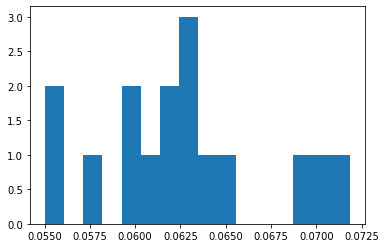

In [28]:
plt.hist(x.cpu().numpy(), bins=len(encoded_imgs_arr[0]))

(array([2., 0., 1., 0., 2., 1., 2., 3., 1., 0., 1., 0., 0., 1., 1., 1.]),
 array([0.05520208, 0.05622397, 0.05724585, 0.05826773, 0.05928962,
        0.0603115 , 0.06133338, 0.06235527, 0.06337715, 0.06439903,
        0.06542092, 0.0664428 , 0.06746468, 0.06848656, 0.06950845,
        0.07053033, 0.07155222], dtype=float32),
 <BarContainer object of 16 artists>)

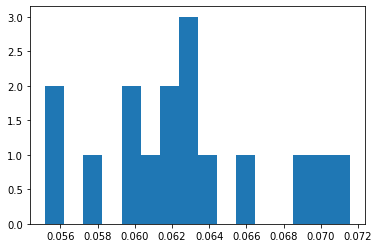

In [29]:
plt.hist(y.cpu().numpy(), bins = len(encoded_imgs_arr[10]))

In [30]:
import random
mse_running_total = 0
arr = []
for i in range(len(encoded_imgs_arr)):
    num = np.square(encoded_imgs_arr[i].cpu().numpy() - encoded_imgs_arr[random.randint(0,len(encoded_imgs_arr)-1)].cpu().numpy()).mean()
    arr.append(num)
    mse_running_total += num
print(f'{mse_running_total=}')

mse_running_total=0.06625559182937374


In [31]:
mse_running_total = 0
for (img, _) in val_loader:
    model.eval()
    with torch.no_grad():

        inp = img.to(device)
        decoded = model(inp)
        mse_running_total += np.square(inp.cpu().numpy() - decoded.cpu().numpy()).mean()
        break

In [32]:
print(inp.size())

torch.Size([1, 3, 225, 225])


torch.Size([3, 225, 225])
0.06133339926600456


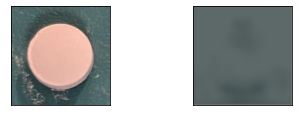

In [33]:
cols = 2
amt = 2
ax = plt.subplot(cols, amt, 1)
img = inp.squeeze()
img = img.detach().cpu().numpy()
plt.imshow(np.transpose(img, (1,2,0))) # changes to rgb
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(cols,amt, 2)
recon = decoded.squeeze()
print(recon.shape)
recon = recon.detach().cpu().numpy()
plt.imshow(np.transpose(recon, (1,2,0)))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

print(mse_running_total)

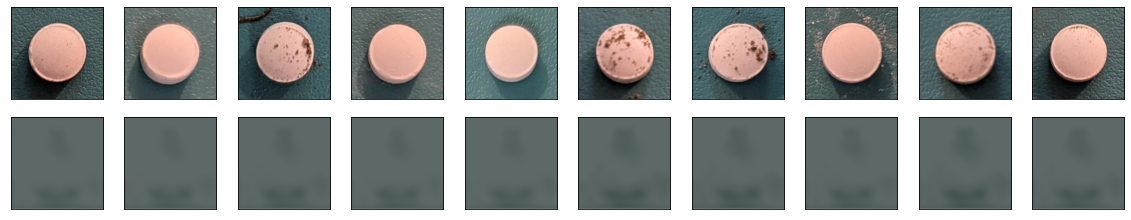

In [34]:
# Validation Set Images
amt = 10
cols = 10
plt.figure(figsize=(20,20))


for k in range(amt):
    
    # input image
    ax = plt.subplot(cols, amt, k+1)
    img = auto_encoder_output[k][0].squeeze()
    img = img.detach().cpu().numpy()
    plt.imshow(np.transpose(img, (1,2,0))) # changes to rgb
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # recon image
    ax = plt.subplot(cols,amt, k+1+amt)
    recon = auto_encoder_output[k+10][1].squeeze()
    recon = recon.detach().cpu().numpy()
    plt.imshow(np.transpose(recon, (1,2,0)))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

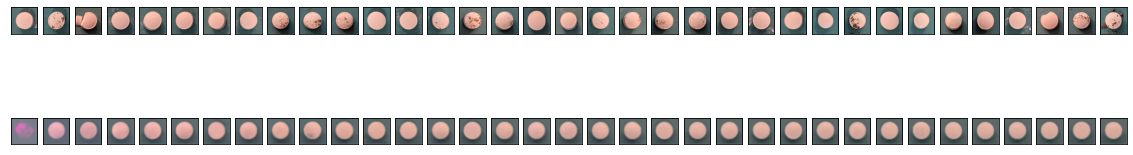

In [35]:
# Training between epochs
amt = len(outputs)
cols = 10
plt.figure(figsize=(20,20))


for k in range(amt):
    
    # input image
    ax = plt.subplot(cols, amt, k+1)
    img = outputs[k][0][0].squeeze()
    img = img.detach().cpu().numpy()
    plt.imshow(np.transpose(img, (1,2,0))) # changes to rgb
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # recon image
    ax = plt.subplot(cols,amt, k+1+amt)
    recon = outputs[k][1][0].squeeze()
    recon = recon.detach().cpu().numpy()
    plt.imshow(np.transpose(recon, (1,2,0)))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [41]:
for i in range(len(auto_encoder_output)-1):
    recon1, recon2 = auto_encoder_output[i][1], auto_encoder_output[i+1][1]
    print(torch.sum(recon1 - recon2))

tensor(-0.2489, device='cuda:0')
tensor(0.8756, device='cuda:0')
tensor(-0.2626, device='cuda:0')
tensor(-5.6138, device='cuda:0')
tensor(7.4324, device='cuda:0')
tensor(-0.6683, device='cuda:0')
tensor(0.6451, device='cuda:0')
tensor(-0.6834, device='cuda:0')
tensor(-0.7923, device='cuda:0')
tensor(0.8338, device='cuda:0')
tensor(-0.3775, device='cuda:0')
tensor(2.8386, device='cuda:0')
tensor(-3.4112, device='cuda:0')
tensor(-0.0397, device='cuda:0')
tensor(0.0844, device='cuda:0')
tensor(1.0365, device='cuda:0')
tensor(-1.3299, device='cuda:0')
tensor(2.5454, device='cuda:0')
tensor(0.4376, device='cuda:0')
tensor(-3.1280, device='cuda:0')
tensor(2.2245, device='cuda:0')
tensor(-0.7780, device='cuda:0')
tensor(-0.1076, device='cuda:0')
tensor(1.4628, device='cuda:0')
tensor(-0.2637, device='cuda:0')
tensor(-3.4468, device='cuda:0')
tensor(1.7268, device='cuda:0')
tensor(0.4359, device='cuda:0')
tensor(-9.1597, device='cuda:0')
tensor(9.9955, device='cuda:0')
tensor(0.4666, device='c

tensor(0.5912, device='cuda:0')
tensor(0.3995, device='cuda:0')
tensor(0.9987, device='cuda:0')
tensor(0.7170, device='cuda:0')
tensor(-2.7908, device='cuda:0')
tensor(1.1652, device='cuda:0')
tensor(-1.4437, device='cuda:0')
tensor(1.6517, device='cuda:0')
tensor(-2.3438, device='cuda:0')
tensor(0.5996, device='cuda:0')
tensor(0.7186, device='cuda:0')
tensor(-1.4384, device='cuda:0')
tensor(1.9357, device='cuda:0')
tensor(0.7747, device='cuda:0')
tensor(-1.4614, device='cuda:0')
tensor(-9.0175, device='cuda:0')
tensor(9.5497, device='cuda:0')
tensor(-0.3816, device='cuda:0')
tensor(1.6249, device='cuda:0')
tensor(0.6597, device='cuda:0')
tensor(-2.6497, device='cuda:0')
tensor(1.6192, device='cuda:0')
tensor(-1.0848, device='cuda:0')
tensor(-0.4096, device='cuda:0')
tensor(0.7300, device='cuda:0')
tensor(0.1893, device='cuda:0')
tensor(-1.9512, device='cuda:0')
tensor(-8.0478, device='cuda:0')
tensor(3.8169, device='cuda:0')
tensor(6.0482, device='cuda:0')
tensor(0.4040, device='cuda: